In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

In [86]:
#     topleft = a[-1,1]
#     topmid = a[0,1]
#     topright = a[1,1]
    
#     midleft = a[-1,0]
#     midmid = a[0,0]
#     midright = a[1,0]
    
#     botleft = a[-1,-1]
#     botmid = a[0,-1]
#     botright = a[1,-1]

In [3]:
@nb.stencil
def kernel1(a, corr):
    c1, c2, c3, c4 = corr
    topleft = a[1,-1]
    topmid = a[1,0]
    topright = a[1,1]
    
    midleft = a[0,-1]
    midmid = a[0,0]
    midright = a[0,1]
    
    botleft = a[-1,-1]
    botmid = a[-1,0]
    botright = a[-1,1]
    
    c1_bl = c1[0,0]
    c1_br = c1[0,1]
    c1_tl = c1[1,0]
    c1_tr = c1[1,1]
    
    Dx_tl = 0.5 * (topmid   - topleft + midmid   - midleft)
    Dx_tr = 0.5 * (topright - topmid  + midright - midmid )
    Dx_bl = 0.5 * (botmid   - botleft + midmid   - midleft)
    Dx_br = 0.5 * (botright - botmid  + midright - midmid )

    Dy_tl = 0.5 * (midmid   - topmid   + midleft - topleft)
    Dy_tr = 0.5 * (midright - topright + midmid  - topmid )
    Dy_bl = 0.5 * (botmid   - midmid   + botleft - midleft)
    Dy_br = 0.5 * (botright - midright + botmid  - midmid )
    
    Dxx = 0.5 * (Dx_tr - Dx_tl + Dx_br - Dx_bl)
    Dyy = 0.5 * (Dy_br - Dy_tr + Dy_bl - Dy_tl)
    Dyx = 0.5 * (Dy_br - Dy_bl + Dy_tr - Dy_tl)
    Dxy = 0.5 * (Dx_br - Dx_tr + Dy_bl - Dx_tl)
    
    return (Dxx + Dyy + Dyx + Dxy)

@nb.stencil
def kernel2(a):
    return (a[0, 1] + a[1, 0] + a[0, -1] + a[-1, 0] - 4.0 * a[0, 0])

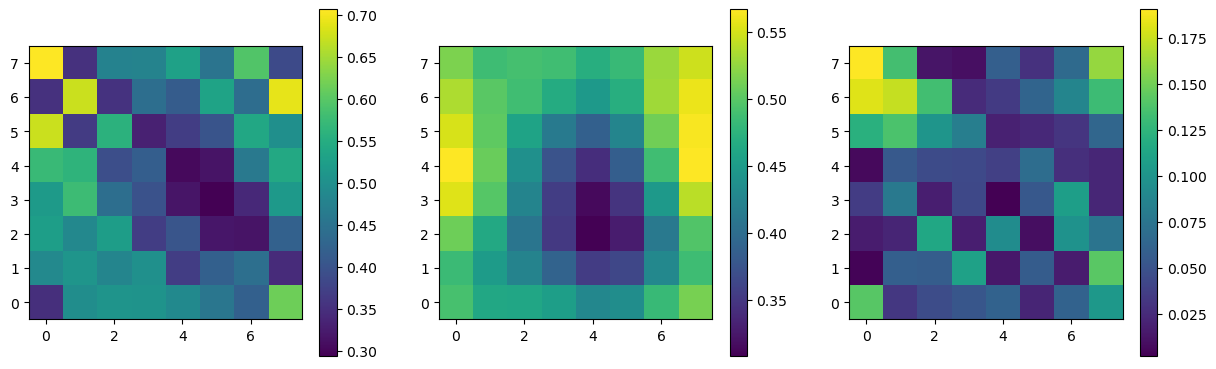

In [4]:
i1 = (slice(1,-1),slice(1,-1))
Nx = 10
dt = 0.1
np.random.seed(555)
zz = np.random.random((Nx,Nx))
zz1 = np.copy(zz)

zz = np.pad(zz[i1], ((1,1),(1,1)), mode='wrap')
zz1 = np.pad(zz1[i1], ((1,1),(1,1)), mode='wrap')

@nb.njit(cache=True)
def looper(zz, zz1, dt):
    for _ in range(10):
        c1 = np.random.random((Nx,Nx))
        c2 = np.random.random((Nx,Nx))
        c3 = np.random.random((Nx,Nx))
        c4 = np.random.random((Nx,Nx))
        corr = (c1,c2,c3,c4)
        zz = periodic(zz)
        zz1 = periodic(zz1)
        zz = zz + dt * kernel1(zz, corr)
        zz1 = zz1 + dt * kernel2(zz1)
        
    return zz, zz1

@nb.njit
def periodic(arr):
    arr[0,:] = arr[-2,:]
    arr[-1,:] = arr[1,:]
    arr[:,0] = arr[:,-2]
    arr[:,-1] = arr[:,1]
    
    return arr
    
zz, zz1 = looper(zz, zz1, dt)

fig, ax = plt.subplots(1,3, figsize=(15,4.5))
im0 = ax[0].imshow(zz[i1], origin='lower')
im1 = ax[1].imshow(zz1[i1], origin='lower')
im2 = ax[2].imshow(np.abs(zz[i1] - zz1[i1]), origin='lower')

plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
plt.show()

In [59]:
@nb.stencil
def _smooth(x):
    return (x[-1, -1] + x[-1, 0] + x[-1, 1] +
            x[ 0, -1] + x[ 0, 0] + x[ 0, 1] +
            x[ 1, -1] + x[ 1, 0] + x[ 1, 1]) // 9

In [60]:
x = np.ones((100, 100))

%timeit _smooth(x)

249 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
x = np.random.random((Nx,Nx))

@nb.njit
def smooth(x):
    for _ in range(10):
        x = x + kernel1(x)
    return kernel1(x)

%timeit smooth(x)

1.02 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
@nb.stencil
def kernel1(a):
    return 0.25 * (a[0, 1] + a[1, 0] + a[0, -1] + a[-1, 0])


In [102]:
input_arr = np.arange(100).reshape((10, 10))
print(input_arr.shape)

(10, 10)


In [103]:
output_arr = kernel1(input_arr)
print(output_arr.shape)

(10, 10)


In [101]:
print(output_arr)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 11. 12. 13. 14. 15. 16. 17. 18.  0.]
 [ 0. 21. 22. 23. 24. 25. 26. 27. 28.  0.]
 [ 0. 31. 32. 33. 34. 35. 36. 37. 38.  0.]
 [ 0. 41. 42. 43. 44. 45. 46. 47. 48.  0.]
 [ 0. 51. 52. 53. 54. 55. 56. 57. 58.  0.]
 [ 0. 61. 62. 63. 64. 65. 66. 67. 68.  0.]
 [ 0. 71. 72. 73. 74. 75. 76. 77. 78.  0.]
 [ 0. 81. 82. 83. 84. 85. 86. 87. 88.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [5]:
A = np.ones((10,10))
print(A)

B = np.arange(11*11).reshape(11,11)
# B[9:] = 0.0
print(B)

@nb.stencil
def C(a,hpx):
    topleft = a[1,-1]
    topmid = a[1,0]
    topright = a[1,1]
    
    midleft = a[0,-1]
    midmid = a[0,0]
    midright = a[0,1]
    
    botleft = a[-1,-1]
    botmid = a[-1,0]
    botright = a[-1,1]
    
    hpx_bl = hpx[0,0]
    hpx_br = hpx[0,1]
    hpx_tl = hpx[1,0]
    hpx_tr = hpx[1,1]
    
    return (topleft + topmid + topright + midleft + midmid + midright + botleft + botmid + botright) * (hpx_bl + hpx_br + hpx_tl + hpx_tr)

print(C(A,B))

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[  0   1   2   3   4   5   6   7   8   9  10]
 [ 11  12  13  14  15  16  17  18  19  20  21]
 [ 22  23  24  25  26  27  28  29  30  31  32]
 [ 33  34  35  36  37  38  39  40  41  42  43]
 [ 44  45  46  47  48  49  50  51  52  53  54]
 [ 55  56  57  58  59  60  61  62  63  64  65]
 [ 66  67  68  69  70  71  72  73  74  75  76]
 [ 77  78  79  80  81  82  83  84  85  86  87]
 [ 88  89  90  91  92  93  94  95  96  97  98]
 [ 99 100 101 102 103 104 105 106 107 108 109]
 [110 111 112 113 114 115 116 117 118 119 120]]
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  648.  684.  720.  756.  792.  828.  864.  900.    0.]
 [   0. 1044. 1080. 1116.

In [24]:
A = np.random.randint(10,size=100).reshape(10,10)
print(A)

@nb.stencil
def C(a):
    topleft = a[1,-1]
    topmid = a[1,0]
    topright = a[1,1]
    
    midleft = a[0,-1]
    midmid = a[0,0]
    midright = a[0,1]
    
    botleft = a[-1,-1]
    botmid = a[-1,0]
    botright = a[-1,1]
    
    return 0.5 * ((topmid - midmid) + (topleft - midleft))

print(C(A))

[[9 7 2 8 3 4 2 9 4 0]
 [4 2 6 0 9 1 0 1 0 9]
 [5 6 5 5 2 2 0 1 9 7]
 [3 5 9 5 5 5 0 6 0 8]
 [6 3 7 7 1 5 3 6 4 9]
 [5 4 1 2 2 1 2 9 7 2]
 [0 2 5 2 4 7 8 9 3 9]
 [2 6 5 5 1 0 4 7 8 8]
 [2 6 4 9 1 3 4 1 8 3]
 [0 8 1 1 8 6 5 3 4 2]]
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   2.5  1.5  2.  -1.  -3.   0.5  0.   4.5  0. ]
 [ 0.  -1.5  1.5  2.   1.5  3.   1.5  2.5 -2.   0. ]
 [ 0.   0.5 -2.   0.  -1.  -2.   1.5  1.5  2.   0. ]
 [ 0.   0.  -2.5 -5.5 -2.  -1.5 -2.5  1.   3.   0. ]
 [ 0.  -3.5  1.   2.   1.   4.   6.   3.  -2.   0. ]
 [ 0.   3.   2.   1.5  0.  -5.  -5.5 -3.   1.5  0. ]
 [ 0.   0.  -0.5  1.5  2.   1.5  1.5 -3.  -3.   0. ]
 [ 0.   0.  -0.5 -5.5 -0.5  5.   2.   1.5 -1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]


In [32]:
0.5 * ((9-0) + (1-1))

4.5

In [11]:
nodes = np.ones((10,10))
nodes = np.arange(10*10).reshape(10,10)
print(nodes)

# cells = 
cells = np.zeros((11,11))
cells[0,:] = np.arange(0,11)
cells[1,:] = np.arange(0,11)
cells[-2:,:] = 10.
cells[:,:2] = 10.
cells[:,-2:] = 10.

# cells = np.pad(cells, ((1,1),(1,1)), mode='constant')
# B[9:] = 0.0
print(cells)

@nb.stencil
def C(a,hpx, hpc):
    topleft = a[1,-1]
    topmid = a[1,0]
    topright = a[1,1]
    
    midleft = a[0,-1]
    midmid = a[0,0]
    midright = a[0,1]
    
    botleft = a[-1,-1]
    botmid = a[-1,0]
    botright = a[-1,1]
    
    hpx_bl = hpx[0,0]
    hpx_br = hpx[0,1]
    hpx_tl = hpx[1,0]
    hpx_tr = hpx[1,1]
    
    print(midmid, hpx_bl, hpx_br, hpx_tl, hpx_tr)
    print(midmid, hpc[0,0])
    print(topleft, topmid, topright)
    print(midleft, midmid, midright)
    print(botleft, botmid, botright)
    
    print("")
    
    return (topleft + topmid + topright + midleft + midmid + midright + botleft + botmid + botright) * (hpx_bl + hpx_br + hpx_tl + hpx_tr)

print(C(nodes,cells, nodes))

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[10. 10.  2.  3.  4.  5.  6.  7.  8. 10. 10.]
 [10. 10.  2.  3.  4.  5.  6.  7.  8. 10. 10.]
 [10. 10.  0.  0.  0.  0.  0.  0.  0. 10. 10.]
 [10. 10.  0.  0.  0.  0.  0.  0.  0. 10. 10.]
 [10. 10.  0.  0.  0.  0.  0.  0.  0. 10. 10.]
 [10. 10.  0.  0.  0.  0.  0.  0.  0. 10. 10.]
 [10. 10.  0.  0.  0.  0.  0.  0.  0. 10. 10.]
 [10. 10.  0.  0.  0.  0.  0.  0.  0. 10. 10.]
 [10. 10.  0.  0.  0.  0.  0.  0.  0. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]
11 10.0 2.0 10.0 0.0
11 11
20 21 22
10 11 12
0 1 2

12 2.0 3.0 0.0 0.0
12 12
21 22 23
11 12 13
1 2 3

13 3.0 4.0 0.0 0.0
13 13
22 23 24
12 13 14
2 3 4


In [10]:
(1+2+3+11+12+13+21+22+23) * (5)

540